# Mountain Car and Q-Learning

The mountain car is a control theory task where you have to get a car on top of a mountain by pushing it gently left and right (and you cannot just push it up directly because the car is too heavy).

In this lecture we will use Q-learning to learn a policy to solve the mountain car.

# Clones, Installs, Imports

## Clone GitHub Repository
This will clone the repository to your machine.  This includes the code and data files.  Then change into the directory of the repository.

In [5]:
!git clone https://github.com/zlisto/reinforcement_learning_tutorial

import os
os.chdir("reinforcement_learning_tutorial")

Cloning into 'reinforcement_learning_tutorial'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 29 (delta 7), reused 28 (delta 6), pack-reused 0
Unpacking objects: 100% (29/29), done.


## Install Packages

In [1]:
!pip install gym pyvirtualdisplay 
!apt-get install -y xvfb python-opengl ffmpeg 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl xvfb
0 upgraded, 2 newly installed, 0 to remove and 62 not upgraded.
Need to get 1,280 kB of archives.
After this operation, 7,687 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 1,280 kB in 0s (12.0 MB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 155639 files and direc

## Import Librarires



In [6]:
from scripts.rl_helper import *

import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay



import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

display = Display(visible=0, size=(1400, 900))
display.start()

# Mountain Car Environment
The name of the simulator environment is `"MountainCar-v0"`, which we save to a variable `env_name`.  We can load the simulator environment with the `gym.make` function.  We use the `wrap_env` function so we can visualize the output of the simulator in Colab.  

Note: You can load many different gym simulator environments with this line of code.  Just change `env_name`.  You can find a list of the gym environments here: https://www.gymlibrary.ml/

## Load Environment

In [3]:
env_name = 'MountainCar-v0'



## Run Environment


In [7]:
env = wrap_env(gym.make(env_name))

observation = env.reset()
score = 0
step = 0
while True:
    env.render()
    step+=1
    # your agent goes here
    action = env.action_space.sample()
    
    observation, reward, done, _ = env.step(action)
    score+=reward
    if done:
        break
print(f"{env_name} Score = {score}, Steps = {step}")
env.close()
show_video()


  



MountainCar-v0 Score = -200.0, Steps = 200


# Q-Learning

We wil train an agent to solve the mountain car using Q-learning.  We will make a Q-table, which is a tensor (a high dimensional matrix) indexed by the states and actions.  The value in each cell of the table equals the rewards that will be achieved if one takes the action when in the given state, and then play the game perfectly.  Q-learning lets us update the values in this table as we play to learn the right policy.  

When we are done, we will have the tensor `Q` which is the Q-table.  To use this table, in each step of the simulator, we check what state we are in.  Then, we look up this row in the table, and choose the action in this row with the highest value.

## Discretize State

To use Q-learning, we need to discretize the state.  That means we assign an integer to each value of the state.  We first calculate how many states we have for the position and velocity.  We save these in the list `num_states`.

In [8]:
n0pts, n1pts = 10, 100
num_states = (env.observation_space.high - env.observation_space.low)*np.array([n0pts, n1pts])
num_states = np.round(num_states, 0).astype(int) + 1

print(f"number of states = {num_states}")


number of states = [19 15]


## Initialize Q-table
We initialize the Q-table as an array with dimensions `(num_states[0], num_states[1], num_actions)`.  We also initialize `reward_list` as a list of the reward of agent after each episode.  


In [9]:
# Initialize Q table
Q = np.random.uniform(low = -1, high = 1, 
                    size = (num_states[0], num_states[1], 
                    env.action_space.n))
print(f"Q table shape = {Q.shape}")

# Initialize rewards list
reward_list = []


Q table shape = (19, 15, 3)


## Initialize Parameters

We choose a few parameters for Q-learning.

1. `learning` = how much we change the Q-table by in each iteration

2. `discount` = hw much we discount past rewards

3. `epsilon` = the probability with which we ignore the Q-table and take a random action (this makes the algorithm not get stuck in loops)

4. `min_epsilon` = lower bound for epsilon

5. `episodes` = the number of episodes of the simulator we play to learn

6. `reduction` = how much we decrease `epsilon` by after each episode.  As we learn more, we want to do random actions less.

In [10]:
learning = 0.2
discount = 0.9
epsilon = 0.8
min_epsilon = 0
episodes = 10000


# Calculate episodic reduction in epsilon after each episode
reduction = epsilon/episodes

## Run Q-learning Algorithm

You can run this loop again to keep training the agent. It will pick up where it left off.

In [16]:
print(f"Running Q-learning on {env_name} for {episodes} episodes")

for i in range(episodes):
    # Initialize parameters
    done = False
    tot_reward = 0  #total rewards for the episode
    state = env.reset()

    # Discretize state
    state_adj = (state - env.observation_space.low)*np.array([n0pts, n1pts])
    state_adj = np.round(state_adj, 0).astype(int)

    while done != True:   
        # Render environment for last two episodes
        if i >= (episodes - 2):
            env.render()

        # Determine next action - epsilon greedy strategy
        if np.random.random() < 1 - epsilon:
            action = np.argmax(Q[state_adj[0], state_adj[1]]) 
        else:
            action = np.random.randint(0, env.action_space.n)

        # Get next state and reward
        state2, reward, done, info = env.step(action) 

        # Discretize state2
        state2_adj = (state2 - env.observation_space.low)*np.array([n0pts, n1pts])
        state2_adj = np.round(state2_adj, 0).astype(int)

        #Allow for terminal states
        if done and state2[0] >= 0.5:
            Q[state_adj[0], state_adj[1], action] = reward

        # Adjust Q value for current state
        else:
            delta = learning*(reward + 
                             discount*np.max(Q[state2_adj[0], 
                                               state2_adj[1]]) - 
                             Q[state_adj[0], state_adj[1],action])
            Q[state_adj[0], state_adj[1],action] += delta

        # Update variables
        tot_reward += reward
        state_adj = state2_adj

    # Decay epsilon
    if epsilon > min_epsilon:
        epsilon -= reduction

    # Track rewards
    reward_list.append(tot_reward)

    if (i+1) % 1000 == 0:
        avg_reward = np.mean(reward_list[-100:]) 
        print(f'Episode {i+1}: 100 episode average reward = {avg_reward}')

env.close()

Running Q-learning on MountainCar-v0 for 10000 episodes
Episode 1000: 100 episode average reward = -148.86
Episode 2000: 100 episode average reward = -148.18
Episode 3000: 100 episode average reward = -147.89
Episode 4000: 100 episode average reward = -144.89
Episode 5000: 100 episode average reward = -144.53
Episode 6000: 100 episode average reward = -146.17
Episode 7000: 100 episode average reward = -145.8
Episode 8000: 100 episode average reward = -145.14
Episode 9000: 100 episode average reward = -145.08
Episode 10000: 100 episode average reward = -143.2


## Plot Rewards vs. Episode

We make a column of the moving average of the rewards using the `rolling` and `mean` functions on the `reward` column of the dataframe.

In [17]:
# Plot Rewards
mavg = 100 #number of episodes to avg rewards over
df = pd.DataFrame({'episode':list(range(len(reward_list))), 
                   'reward':reward_list})
df[f'reward_{mavg}mavg'] = df.reward.rolling(mavg).mean().fillna(0)


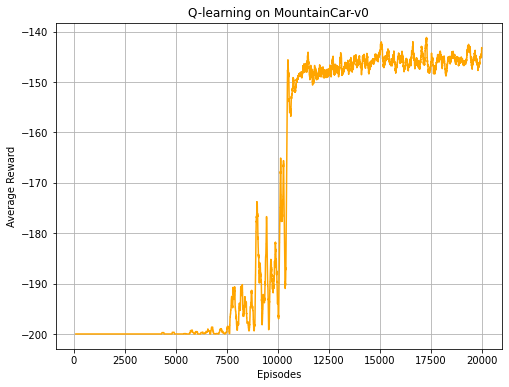

In [18]:
fig = plt.figure(figsize = (8,6))
sns.lineplot(data = df[mavg:], x='episode', 
             y = f'reward_{mavg}mavg',
            color = 'orange')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title(f'Q-learning on {env_name}')
plt.grid()
plt.show()

## Check Trained Q-Table

Input some state values and see what the trained Q-table looks like.  Remember, the action you take corresponds to the column with the highest Q-value.

In [19]:
state_x = 18 #0 <= state_x <= 18
state_vel = 14  #0 <= state_vel <= 14

print(f"Q[x={state_x},vel={state_vel},:] = {Q[state_x,state_vel,:]}")

Q[x=18,vel=14,:] = [ 0.06019488 -0.87837692  0.31138609]


# Test Trained Agent

In [20]:
env = wrap_env(gym.make(env_name))

state = env.reset()
score = 0
step = 0
while True:
    env.render()
    step+=1
    # your agent goes here
    state_adj = (state - env.observation_space.low)*np.array([n0pts, n1pts])
    state_adj = np.round(state_adj, 0).astype(int)
    

    action = np.argmax(Q[state_adj[0], state_adj[1]]) 

        
    state, reward, done, _ = env.step(action)
    score+=reward
    if done:
        break
print(f"{env_name} Score = {score}, Steps = {step}")
env.close()
show_video() 





MountainCar-v0 Score = -142.0, Steps = 142
